In [1]:
import torch
import numpy as np
import zuko
import matplotlib.pyplot as plt
import torch.utils.data as data

from toy_dataset import get_data_sin_rand, get_data_sin

In [2]:
# 2. Get and normalize data
raw_data = get_data_sin_rand(0, 12)
data_mean = raw_data.mean(dim=0)
data_std = raw_data.std(dim=0)
data = (raw_data - data_mean) / data_std

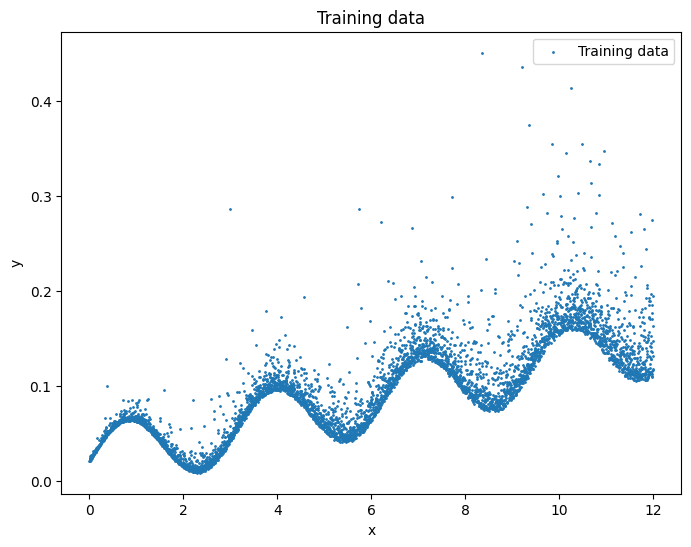

In [3]:
# Plot original data
x = raw_data[:, 0].numpy()
y = raw_data[:, 1].numpy()
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=1, label='Training data')
plt.title("Training data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

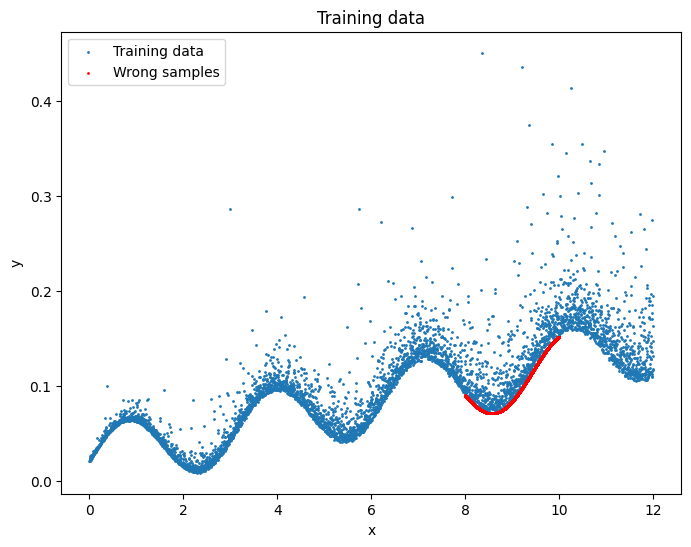

In [4]:
wrong_samples = get_data_sin(8, 10)
x_wrong = wrong_samples[:, 0].numpy()
y_wrong = wrong_samples[:, 1].numpy()
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=1, label='Training data')
plt.scatter(x_wrong, y_wrong, s=1, color='red', label='Wrong samples')
plt.title("Training data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [5]:
# 3. Data loader
batch_size = 64
trainset = torch.utils.data.TensorDataset(data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
# 4. Define conditional flow: p(y | x)
flow = zuko.flows.BPF(features=1, context=1, degree=20, hidden_features=(64, 64))

In [7]:
# 5. Training
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
loss_hist = []

for epoch in range(200):
    losses = []

    for (batch,) in trainloader:
        x_ctx = batch[:, 0:1]  # context (x)
        y_val = batch[:, 1:2]  # target (y)

        loss = -flow(x_ctx).log_prob(y_val).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)
    loss_hist.append(losses.mean().item())
    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 1.2311820983886719 ± 0.19579672813415527
(1) 0.975414514541626 ± 0.1318734884262085
(2) 0.9091871976852417 ± 0.10985767841339111
(3) 0.8816946744918823 ± 0.1263066977262497
(4) 0.8676035404205322 ± 0.13566423952579498
(5) 0.8585373163223267 ± 0.1346461921930313
(6) 0.8439212441444397 ± 0.12905903160572052
(7) 0.8338850736618042 ± 0.10423530638217926
(8) 0.8206508159637451 ± 0.1313657909631729
(9) 0.8031889796257019 ± 0.12805600464344025
(10) 0.7881767153739929 ± 0.12708960473537445
(11) 0.7747926115989685 ± 0.1287015676498413
(12) 0.7518097162246704 ± 0.13809090852737427
(13) 0.7356235384941101 ± 0.12681692838668823
(14) 0.7138000726699829 ± 0.12470530718564987
(15) 0.7052940726280212 ± 0.17270001769065857
(16) 0.6691295504570007 ± 0.13729149103164673
(17) 0.6466814875602722 ± 0.12008585035800934
(18) 0.6213379502296448 ± 0.1294482946395874
(19) 0.6015616059303284 ± 0.1478257030248642
(20) 0.569118857383728 ± 0.1401386708021164
(21) 0.5374866724014282 ± 0.14473780989646912
(22) 0.5

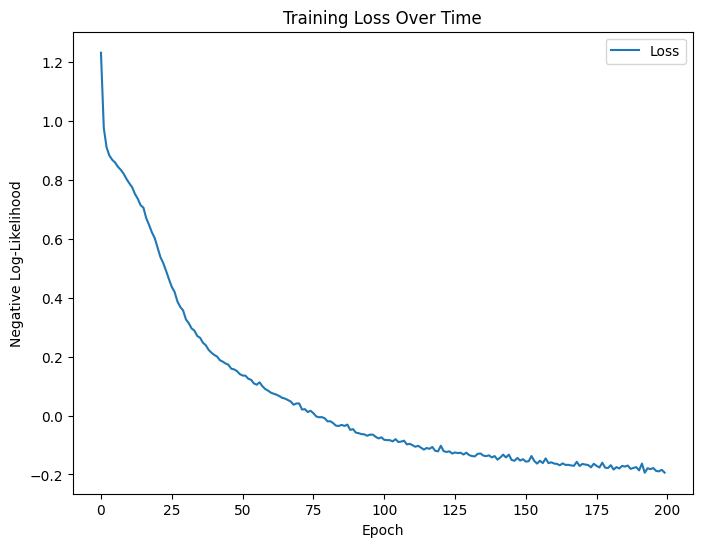

In [8]:
# 6. Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss_hist, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

In [9]:
# 7. Sample from the learned distribution p(y | x)
x_values = torch.linspace(8, 10, 20).unsqueeze(1)
x_values_norm = (x_values - data_mean[0]) / data_std[0]  # normalize x
samples_norm = flow(x_values_norm).sample((100,))  # (100, 500, 1)
samples = samples_norm * data_std[1] + data_mean[1]  # denormalize y

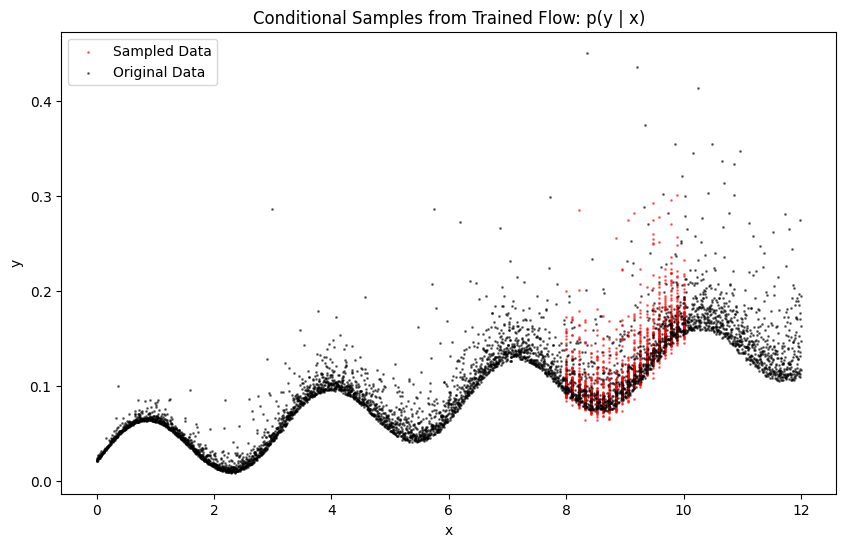

In [10]:
# 8. Plot the sampled y's conditioned on x
plt.figure(figsize=(10, 6))
for i in range(100):  # 100 sampled functions
    plt.scatter(x_values.numpy(), samples[i, :, 0].numpy(), s=1, color='red', alpha=0.5, label="Sampled Data" if i == 0 else "")
plt.scatter(raw_data[:, 0].numpy(), raw_data[:, 1].numpy(), s=1, color='black', alpha=0.5, label="Original Data")
plt.title("Conditional Samples from Trained Flow: p(y | x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper left')
plt.show()

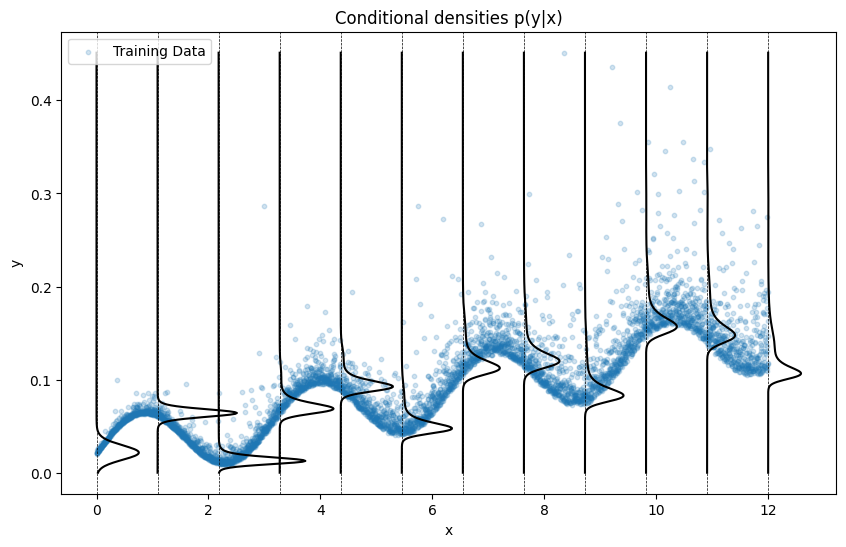

In [11]:
# 9. Plot conditional densities for fixed x values
import seaborn as sns
from scipy.stats import gaussian_kde

y_max = raw_data[:, 1].numpy().max()

x_slices = torch.linspace(0, 12, 12)
ys = torch.linspace(0, y_max, 500)

plt.figure(figsize=(10, 6))

# Normalize x and y
x_slices_norm = (x_slices - data_mean[0]) / data_std[0]
ys_norm = (ys - data_mean[1]) / data_std[1]

for x_val, x_val_norm in zip(x_slices, x_slices_norm):
    x_context = x_val_norm.unsqueeze(0).unsqueeze(0).expand(ys.shape[0], -1)  # shape (500, 1)
    y_eval = ys_norm.unsqueeze(1)  # shape (500, 1)

    with torch.no_grad():
        log_probs = flow(x_context).log_prob(y_eval)
        probs = torch.exp(log_probs).numpy()

    # Scale and shift to x-position for ridge plot
    probs_scaled = probs * 0.3  # scale for display
    plt.plot(probs_scaled + x_val.item(), ys, color='black')

    # Optional: draw vertical reference line
    plt.axvline(x_val.item(), color='black', linestyle='dashed', linewidth=0.5)

plt.scatter(raw_data[:, 0], raw_data[:, 1], alpha=0.2, s=10, label='Training Data')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Conditional densities p(y|x)")
plt.legend(loc='upper left')
plt.show()
